# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

# Initial data loading and basic info

In [2]:
# load in the data
azdias = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

d:\Code\udacity\udacity_ds_capstone\.venv\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [5]:
# Checking columns indicated by the warning (18 and 19)
warned_cols = azdias[azdias.columns[18:20]]
warned_cols

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN
1,8.0,51.0
2,4.0,24.0
3,2.0,12.0
4,6.0,43.0
...,...,...
891216,7.0,41.0
891217,9.0,51.0
891218,4.0,24.0
891219,9.0,51.0


In [6]:
warned_cols.describe()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
count,792242,792242
unique,19,43
top,8,51
freq,78023,77576


In [7]:
warned_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   CAMEO_DEUG_2015  792242 non-null  object
 1   CAMEO_INTL_2015  792242 non-null  object
dtypes: object(2)
memory usage: 13.6+ MB


In [8]:
# Trying to convert those to numeric
try:
    warned_cols.applymap(pd.to_numeric)
except Exception as e:
    print('EXCEPTION', e)

EXCEPTION Unable to parse string "X" at position 0


Apparently, **there are strings mixed in with the float values** in these columns. In the next section, we'll check all columns interpreted as `object` by pandas and try to clean them up.

# Data cleanup

## Interpreting columns labeled as `object`

In [9]:
azdias[[c for c in azdias.columns if azdias[c].dtype == object]]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7.0,41.0,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9.0,51.0,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4.0,24.0,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9.0,51.0,D19_UNBEKANNT,1992-02-12 00:00:00,W


The columns interpreted as `object` by pandas are:
- `CAMEO_DEU_2015` : Appears to be a true categorical feature.
- `CAMEO_DEUG_2015` : Should be mapped to purely numeric.
- `CAMEO_INTL_2015` : Should be mapped to purely numeric.
- `D19_LETZTER_KAUF_BRANCHE` : Appears to be a true categorical feature.
- `EINGEFUEGT_AM` : Should be mapped to a datetime.
- `OST_WEST_KZ` : Appears to be categorical, but we should verify whether there are multiple values.

We'll start by removing invalid values (strings) from the numeric cols `[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']]`

In [10]:
# Check if `customers` has the same problem
try:
    customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].applymap(pd.to_numeric)
except Exception as e:
    print('EXCEPTION', e)

EXCEPTION Unable to parse string "X" at position 0


In [11]:
def replace_invalid(value) -> float:
    """Tries to cast a value as float, otherwise returns NaN"""
    if pd.isna(value):
        # If value is already NaN, keep it as is
        return value
    
    else:
        try:
            out = float(value)
        except Exception as e:
            # If cast raises an error, return NaN
            out = np.nan

        return out

# Replace non numeric values with NaN
azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].applymap(replace_invalid)
customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']].applymap(replace_invalid)


In [12]:
# Convert EINGEFUEGT_AM to datetime in both datasets
customers['EINGEFUEGT_AM'] = pd.to_datetime(customers['EINGEFUEGT_AM'])
azdias['EINGEFUEGT_AM'] = pd.to_datetime(azdias['EINGEFUEGT_AM'])

In [13]:
# Check how many unique values there are in OST_WEST_KZ
azdias['OST_WEST_KZ'].value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [14]:
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [15]:
# Finally, let's look again for columns interpreted as `object`
azdias[[c for c in azdias.columns if azdias[c].dtype == object]].sample(10)

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
420989,6B,D19_VOLLSORTIMENT,O
840323,2D,NaN,O
716773,2D,D19_SCHUHE,W
594220,NaN,NaN,NaN
278909,NaN,D19_UNBEKANNT,NaN
755064,7A,D19_BEKLEIDUNG_REST,W
349635,8B,D19_SONSTIGE,W
728857,8D,NaN,O
866228,3D,D19_SONSTIGE,W
36851,2C,D19_VERSAND_REST,O


In [16]:
customers[[c for c in customers.columns if customers[c].dtype == object]].sample(10)

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
109298,6E,D19_VERSICHERUNGEN,O,COSMETIC_AND_FOOD,MULTI_BUYER
13605,4A,D19_SONSTIGE,W,COSMETIC_AND_FOOD,MULTI_BUYER
61566,3D,D19_LEBENSMITTEL,W,FOOD,SINGLE_BUYER
18457,4D,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
56024,6F,D19_VOLLSORTIMENT,W,COSMETIC_AND_FOOD,MULTI_BUYER
12891,8D,D19_TELKO_MOBILE,O,COSMETIC_AND_FOOD,MULTI_BUYER
26883,2C,D19_UNBEKANNT,W,COSMETIC_AND_FOOD,MULTI_BUYER
153918,3B,D19_SCHUHE,W,COSMETIC_AND_FOOD,MULTI_BUYER
101507,4C,D19_SAMMELARTIKEL,W,FOOD,MULTI_BUYER
128013,4C,D19_VERSICHERUNGEN,W,COSMETIC_AND_FOOD,MULTI_BUYER


Columns interpreted as `object` are now purely categorical. There are two extra `object` columns in `customers` related to the extra data about customer behaviour.

In [17]:
customer_only_columns = [c for c in customers.columns if c not in azdias.columns]
customer_only_columns

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

## Unique columns

In [18]:
print('Columns in `customers` with unique values for each individual row:')
print([c for c in customers if customers[c].is_unique])

print('Columns in `azdias` with unique values for each individual row:')
print([c for c in azdias if azdias[c].is_unique])

Columns in `customers` with unique values for each individual row:
['LNR']
Columns in `azdias` with unique values for each individual row:
['LNR']


`LNR` is probably short for "line number", relating to a unique index. We'll set this column as an index and drop it.

In [19]:
customers = customers.set_index('LNR', drop=True)
azdias = azdias.set_index('LNR', drop=True)

# Interpreting column info
In this section we'll use the column description files as a basis for interpreting the values present in the datasets.

In [20]:
# Reading and formatting the "Info Levels" spreadsheet
info_levels = pd.read_excel('data/DIAS Information Levels - Attributes 2017.xlsx', engine='openpyxl')
del info_levels['Unnamed: 0']
info_levels.columns = info_levels.iloc[0].values
info_levels.drop(0, inplace=True)
info_levels['Information level'] = info_levels['Information level'].ffill().bfill()
info_levels

,Information level,Attribute,Description,Additional notes
1,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
2,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
3,Person,ANREDE_KZ,gender,NaN
4,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
5,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
...,...,...,...,...
309,Community,ARBEIT,share of unemployed person in the community,NaN
310,Community,EINWOHNER,inhabitants,NaN
311,Community,GKZ,standardized community-code,NaN
312,Community,ORTSGR_KLS9,classified number of inhabitants,NaN


In [21]:
# Reading and formatting the "Attributes" spreadsheet
dias_atts = pd.read_excel('data/DIAS Attributes - Values 2017_Modified.xlsx', engine='openpyxl')
del dias_atts['Unnamed: 0']
dias_atts.columns = dias_atts.iloc[0].values
dias_atts.drop(0, inplace=True)
dias_atts['Attribute'] = dias_atts['Attribute'].ffill()
dias_atts

,Attribute,Description,Value,Meaning,Type,isna
1,AGER_TYP,best-ager typology,-1,unknown,c,True
2,AGER_TYP,NaN,0,no classification possible,NaN,True
3,AGER_TYP,NaN,1,passive elderly,NaN,NaN
4,AGER_TYP,NaN,2,cultural elderly,NaN,NaN
5,AGER_TYP,NaN,3,experience-driven elderly,NaN,NaN
...,...,...,...,...,...,...
2257,ZABEOTYP,NaN,2,smart,NaN,NaN
2258,ZABEOTYP,NaN,3,fair supplied,NaN,NaN
2259,ZABEOTYP,NaN,4,price driven,NaN,NaN
2260,ZABEOTYP,NaN,5,seeking orientation,NaN,NaN


In [22]:
from typing import Tuple

def check_columns_in_series(df : pd.DataFrame, series : pd.Series, verbose : bool = True) -> Tuple[list, list]:
    """
    Description:
        Checks for intersection between columns in df and column names in a series.
        Used in this context to determine which columns of a dataset are described 
        in a separate "column description" table.

    Arguments:
        df : The dataset in pd.DataFrame format.
        series : A pd.Series supposedly containing column names in `df`
        verbose : Flag indicating whether to print results (default True)

    Returns:
        not_found : A list containing all column names in `series` not present in `df`
        remaining : A list of columns present in `df` but not in `series`
    """

    not_found = []
    remaining = list(df.columns)
    for att in series.dropna().unique():
        if not att in df.columns:
            not_found.append(att)
        else:
            remaining.remove(att)

    if verbose:
        print('Attributes not found in DataFrame:')
        print(not_found)

        print('\nAttributes in the DataFrame without description:')
        print(remaining)

    return not_found, remaining


In [23]:
not_found, remaining = check_columns_in_series(customers, dias_atts['Attribute'])

Attributes not found in DataFrame:
['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BANKEN_DIREKT_RZ', 'D19_BANKEN_GROSS_RZ', 'D19_BANKEN_LOKAL_RZ', 'D19_BANKEN_REST_RZ', 'D19_BEKLEIDUNG_GEH_RZ', 'D19_BEKLEIDUNG_REST_RZ', 'D19_BILDUNG_RZ', 'D19_BIO_OEKO_RZ', 'D19_BUCH_RZ', 'D19_DIGIT_SERV_RZ', 'D19_DROGERIEARTIKEL_RZ', 'D19_ENERGIE_RZ', 'D19_FREIZEIT_RZ', 'D19_GARTEN_RZ', 'D19_HANDWERK_RZ', 'D19_HAUS_DEKO_RZ', 'D19_KINDERARTIKEL_RZ', 'D19_KK_KUNDENTYP', 'D19_KOSMETIK_RZ', 'D19_LEBENSMITTEL_RZ', 'D19_LOTTO_RZ', 'D19_NAHRUNGSERGAENZUNG_RZ', 'D19_RATGEBER_RZ', 'D19_REISEN_RZ', 'D19_SAMMELARTIKEL_RZ', 'D19_SCHUHE_RZ', 'D19_SONSTIGE_RZ', 'D19_TECHNIK_RZ', 'D19_TELKO_MOBILE_RZ', 'D19_TELKO_REST_RZ', 'D19_TIERARTIKEL_RZ', 'D19_VERSAND_REST_RZ', 'D19_VERSICHERUNGEN_RZ', 'D19_VOLLSORTIMENT_RZ', 'D19_WEIN_FEINKOST_RZ', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'SOHO_FLAG', 'WACHSTUMSGEBIET_NB']

Attributes in the DataFrame without description:
['AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2

There are many non-intersecting features where names are very similar (`D19_ENERGIE` and `D19_ENERGIE_RZ`, for example). Let's try to match those with a simple heuristic. Furthermore, we can use more sophisticated methods to match features and descriptions.

In [24]:
matched = {}    # A dictionary mapping cols in the original data
                # without descriptions in the meta file to possible cols with slightly different names
remaining_ = remaining.copy()
not_found_ = not_found.copy()

# Simple heuristic from looking at the column names
for col in remaining:
    if col + '_RZ' in not_found:
        matched[col + '_RZ'] = col
        remaining_.remove(col)
        not_found_.remove(col + '_RZ')

# Reassign altered copies to original variables
remaining = remaining_
not_found = not_found_

print(len(matched), 'attributes were matched')
print('\nRemaining columns in the Series not found in the DataFrame:')
print(not_found)

print('\nRemaining columns in the DataFrame without description:')
print(remaining)

33 attributes were matched

Remaining columns in the Series not found in the DataFrame:
['BIP_FLAG', 'CAMEO_DEUINTL_2015', 'D19_BUCH_RZ', 'D19_KK_KUNDENTYP', 'GEOSCORE_KLS7', 'HAUSHALTSSTRUKTUR', 'KBA13_CCM_1400_2500', 'SOHO_FLAG', 'WACHSTUMSGEBIET_NB']

Remaining columns in the DataFrame without description:
['AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER', 'ANZ_STATISTISCHE_HAUSHALTE', 'ARBEIT', 'CAMEO_INTL_2015', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BUCH_CD', 'D19_KONSUMTYP_MAX', 'D19_LETZTER_KAUF_BRANCHE', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'DSL_FLAG', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR', 'EXTSEL992', 'FIRMENDICHTE', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_CCM_1401_25

We successfully matched 33 features to their descriptions simply by adding `_RZ` to the end of the column names. We'll try to match the remaining columns in the dataframe using a distance metric.

In [25]:
from distance import levenshtein

# Create a levenshtein distance matrix between the remaining columns
dist = pd.DataFrame(index=remaining, columns=not_found, dtype=int)
for r in dist.index:
    for n in dist.columns:
        dist.loc[r, n] = levenshtein(r, n)

dist

,BIP_FLAG,CAMEO_DEUINTL_2015,D19_BUCH_RZ,D19_KK_KUNDENTYP,GEOSCORE_KLS7,HAUSHALTSSTRUKTUR,KBA13_CCM_1400_2500,SOHO_FLAG,WACHSTUMSGEBIET_NB
AKT_DAT_KL,9.0,13.0,9.0,13.0,10.0,14.0,16.0,10.0,14.0
ALTER_KIND1,10.0,13.0,11.0,12.0,11.0,13.0,17.0,10.0,15.0
ALTER_KIND2,10.0,13.0,11.0,12.0,11.0,13.0,16.0,10.0,15.0
ALTER_KIND3,10.0,14.0,11.0,12.0,11.0,13.0,17.0,10.0,15.0
ALTER_KIND4,10.0,14.0,11.0,12.0,11.0,13.0,17.0,10.0,15.0
...,...,...,...,...,...,...,...,...,...
VK_DISTANZ,9.0,14.0,9.0,13.0,13.0,15.0,18.0,9.0,15.0
VK_ZG11,7.0,16.0,10.0,14.0,12.0,17.0,17.0,8.0,17.0
PRODUCT_GROUP,12.0,14.0,10.0,15.0,12.0,14.0,17.0,11.0,17.0
CUSTOMER_GROUP,13.0,15.0,12.0,15.0,11.0,13.0,18.0,11.0,13.0


In [26]:
# Find the closest attributes for each remaining column in the dataframe and sort by distance
closest = pd.DataFrame(columns=['closest', 'distance'], index=dist.index)
closest['closest'] = closest.apply(lambda x: dist.loc[x.name].sort_values().index[0], axis=1)
closest['distance'] = closest.apply(lambda x: dist.loc[x.name].sort_values().values[0], axis=1)
closest.sort_values('distance').head(60)

,closest,distance
KBA13_CCM_1401_2500,KBA13_CCM_1400_2500,1.0
D19_BUCH_CD,D19_BUCH_RZ,2.0
DSL_FLAG,BIP_FLAG,3.0
CAMEO_INTL_2015,CAMEO_DEUINTL_2015,3.0
SOHO_KZ,SOHO_FLAG,4.0
KK_KUNDENTYP,D19_KK_KUNDENTYP,4.0
VHA,BIP_FLAG,7.0
VK_ZG11,BIP_FLAG,7.0
KBA13_ANTG2,BIP_FLAG,8.0
KOMBIALTER,SOHO_FLAG,8.0


There seems to be some attributes that we can still match with this approach:
- `KBA13_CCM_1401_2500` is very similar in name to `KBA13_CCM_1400_2500`. We should check the values and description to come to a conclusion.
- `D19_BUCH_CD` and `D19_BUCH_RZ` are also very close.
- `CAMEO_INTL_2015` could be matched to `CAMEO_DEUINTL_2015`
- `KK_KUNDENTYP` is probably the same as `D19_KK_KUNDENTYP`
- `SOHO_KZ` should be related to `SOHO_FLAG`. We should check if it is a binary feature.

In [27]:
azdias[['KBA13_CCM_1401_2500', 'D19_BUCH_CD', 'CAMEO_INTL_2015', 'KK_KUNDENTYP', 'SOHO_KZ']]

,KBA13_CCM_1401_2500,D19_BUCH_CD,CAMEO_INTL_2015,KK_KUNDENTYP,SOHO_KZ
LNR,,,,,
910215,NaN,0,NaN,NaN,NaN
910220,3.0,0,51.0,NaN,1.0
910225,3.0,0,24.0,NaN,0.0
910226,2.0,6,12.0,NaN,0.0
910241,1.0,6,43.0,1.0,0.0
...,...,...,...,...,...
825761,4.0,4,41.0,3.0,0.0
825771,3.0,0,51.0,NaN,0.0
825772,3.0,6,24.0,NaN,0.0


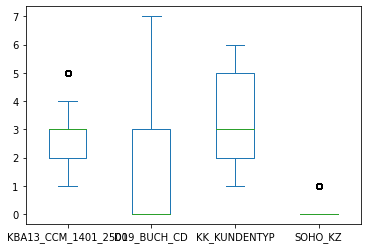

In [28]:
azdias[['KBA13_CCM_1401_2500', 'D19_BUCH_CD', 'KK_KUNDENTYP', 'SOHO_KZ']].plot.box();

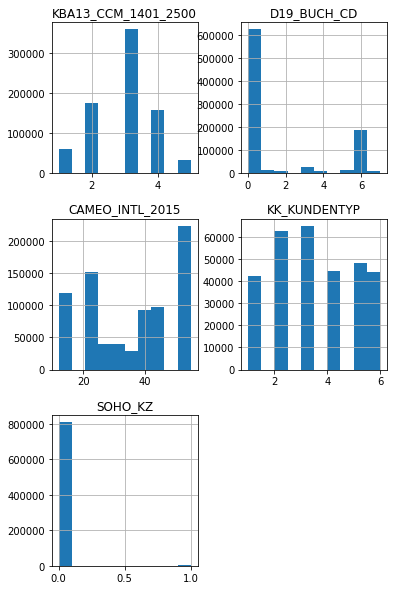

In [29]:
azdias[['KBA13_CCM_1401_2500', 'D19_BUCH_CD', 'CAMEO_INTL_2015', 'KK_KUNDENTYP', 'SOHO_KZ']].hist(figsize=(6, 10));

In [30]:
customers['SOHO_KZ'].value_counts()

0.0    143625
1.0      1431
Name: SOHO_KZ, dtype: int64

Upon inspecting value ranges and comparing with the descriptions for each of these 5 features, it is clear that they are indeed the same attribute. We'll add these to the `matched` dictionary and remove them from the corresponding lists


In [31]:
for remaining_col in ['KBA13_CCM_1401_2500', 'D19_BUCH_CD', 'CAMEO_INTL_2015', 'KK_KUNDENTYP', 'SOHO_KZ']:
    remaining.remove(remaining_col)
    matched_name = closest.loc[remaining_col]['closest']
    print(matched_name, '->', remaining_col)
    not_found.remove(matched_name)
    matched[matched_name] = remaining_col


KBA13_CCM_1400_2500 -> KBA13_CCM_1401_2500
D19_BUCH_RZ -> D19_BUCH_CD
CAMEO_DEUINTL_2015 -> CAMEO_INTL_2015
D19_KK_KUNDENTYP -> KK_KUNDENTYP
SOHO_FLAG -> SOHO_KZ


With some translation work we can also conclude that `ANZ_KINDER` means "Number of children" and `ALTER_KIND1` through 4 relates to the age of each child (up to 4).

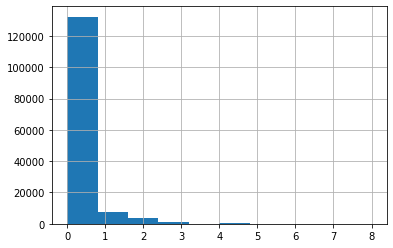

In [32]:
customers['ANZ_KINDER'].hist();

<AxesSubplot:>

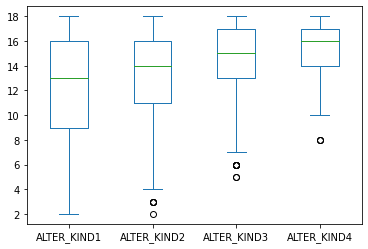

In [33]:
customers[[f'ALTER_KIND{i}' for i in range(1, 5)]].plot.box()

We can now remove these columns from the `remaining` list

In [34]:
for col in ['ANZ_KINDER'] + [f'ALTER_KIND{i}' for i in range(1, 5)]:
    remaining.remove(col)

remaining

['AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_KONSUMTYP_MAX',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSI_ONLINE_QUOTE_12',
 'DSL_FLAG',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'FIRMENDICHTE',
 'GEMEINDETYP',
 'HH_DELTA_FLAG',
 'KBA13_ANTG1',
 'KBA13_ANTG2',
 'KBA13_ANTG3',
 'KBA13_ANTG4',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HHZ',
 'KBA13_KMH_210',
 'KOMBIALTER',
 'KONSUMZELLE',
 'MOBI_RASTER',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'UNGLEICHENN_FLAG',
 'VERDICHTUNGSRAUM',
 'VHA',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11',
 'PRODUCT_GROUP',
 'CUSTOMER_GROUP',
 'ONLINE_PURCHASE']

Considering the ALTER_KIND columns, we will look at the missing values and try to keep these columns in the dataset.

In [36]:
azdias[[c for c in azdias.columns if 'KIND' in c]].isna().mean()

ALTER_KIND1          0.909048
ALTER_KIND2          0.966900
ALTER_KIND3          0.993077
ALTER_KIND4          0.998648
ANZ_KINDER           0.082470
D19_KINDERARTIKEL    0.000000
W_KEIT_KIND_HH       0.120735
dtype: float64

We can see a large number of missing values for all columns regarding children age. This probably relates to the number of children that an individual has.

In [41]:
azdias[[c for c in azdias.columns if 'KIND' in c]].groupby('ANZ_KINDER').apply(lambda x: x.isna().mean())

,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_KINDER,D19_KINDERARTIKEL,W_KEIT_KIND_HH
ANZ_KINDER,,,,,,,
0.0,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.042844
1.0,0.096116,0.996712,0.999693,0.999964,0.0,0.0,0.040416
2.0,0.003886,0.072612,0.997914,0.999795,0.0,0.0,0.017918
3.0,0.000558,0.006138,0.106213,0.996652,0.0,0.0,0.015253
4.0,0.001892,0.002838,0.009461,0.117313,0.0,0.0,0.014191
5.0,0.005263,0.005263,0.005263,0.021053,0.0,0.0,0.005263
6.0,0.021277,0.021277,0.021277,0.021277,0.0,0.0,0.000000
7.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.100000
8.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


We can see that only a small percentage of the missing values are missing because of incomplete data. In other words, the majority of missing values for these columns come from the fact that that child doesn't actually exist. We'll remap the missing values to 0 in those columns to reflect that.

In [44]:
kinder_cols = [c for c in azdias.columns if 'ALTER_KIND' in c]
azdias[kinder_cols] = azdias[kinder_cols].fillna(0)
customers[kinder_cols] = customers[kinder_cols].fillna(0)

azdias[kinder_cols].isna().mean()

ALTER_KIND1    0.0
ALTER_KIND2    0.0
ALTER_KIND3    0.0
ALTER_KIND4    0.0
dtype: float64

Back to the mismatched columns:

In [45]:
# The last "not found" attributes in the column description file
dias_atts[dias_atts.Attribute.isin(not_found_)].dropna()

,Attribute,Description,Value,Meaning,Type,isna
49,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown,c,True
725,GEOSCORE_KLS7,microgeographical risk index concerning popula...,"-1, 0",unknown,o,True
735,HAUSHALTSSTRUKTUR,"structure of the household (single-hh, couple ...","-1, 0",unknown,c,True
2242,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown,o,True


Let's update the dias_atts and info_levels dataframes with the matched feature names and save them to disk for further use.

In [46]:
(dias_atts['Attribute'].replace(matched).unique() != dias_atts['Attribute'].unique()).sum()

38

In [47]:
(info_levels['Attribute'].replace(matched).unique() != info_levels['Attribute'].unique()).sum()

37

In [48]:
dias_atts['Attribute'] = dias_atts['Attribute'].replace(matched)
info_levels['Attribute'] = info_levels['Attribute'].replace(matched)

dias_atts.to_csv('data/clean/dias_atts.csv', index=None)
info_levels.to_csv('data/clean/info_levels.csv', index=None)

# Missing values
In this section, we'll use our interpreted columns from earlier to find "unknown" values in the data that may not have been marked as NaN.

In [58]:
# We'll create a dictionary consisting of values to be cast to NaN for each attribute
unknown_mapping = dias_atts[~dias_atts['isna'].isna()].copy()
# use our earlier "matched" dictionary to replace attribute names in unknown_mapping
unknown_mapping['Attribute'] = unknown_mapping['Attribute'].replace(matched)
unknown_mapping

,Attribute,Description,Value,Meaning,Type,isna
1,AGER_TYP,best-ager typology,-1,unknown,c,True
2,AGER_TYP,NaN,0,no classification possible,NaN,True
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,o,True
11,ALTERSKATEGORIE_GROB,NaN,9,uniformly distributed,NaN,True
12,ALTER_HH,main age within the household,0,unknown / no main age detectable,i,True
...,...,...,...,...,...,...
2233,WOHNLAGE,residential-area,-1,unknown,c,True
2234,WOHNLAGE,NaN,0,no score calculated,NaN,True
2242,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown,o,True
2248,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown,o,True


In [59]:
unknown_mapping_dict = {}
grouped = unknown_mapping.groupby('Attribute')

for g in grouped.groups:
    nan_vals = (grouped.get_group(g)['Value'].map(str)+',').sum().strip(',').split(',')
    nan_vals = [int(val) for val in nan_vals]
    unknown_mapping_dict[g] = {k: np.nan for k in nan_vals}

# Extra feature `nan` mapping found after looking at the histograms
unknown_mapping_dict['ALTERSKATEGORIE_FEIN'] = {0: np.nan}
unknown_mapping_dict

{'AGER_TYP': {-1: nan, 0: nan},
 'ALTERSKATEGORIE_GROB': {-1: nan, 0: nan, 9: nan},
 'ALTER_HH': {0: nan},
 'ANREDE_KZ': {-1: nan, 0: nan},
 'BALLRAUM': {-1: nan},
 'BIP_FLAG': {-1: nan},
 'CAMEO_DEUG_2015': {-1: nan},
 'CAMEO_INTL_2015': {-1: nan},
 'CJT_GESAMTTYP': {0: nan},
 'D19_BANKEN_ANZ_12': {0: nan},
 'D19_BANKEN_ANZ_24': {0: nan},
 'D19_BANKEN_DATUM': {10: nan},
 'D19_BANKEN_DIREKT': {0: nan},
 'D19_BANKEN_GROSS': {0: nan},
 'D19_BANKEN_LOKAL': {0: nan},
 'D19_BANKEN_OFFLINE_DATUM': {10: nan},
 'D19_BANKEN_ONLINE_DATUM': {10: nan},
 'D19_BANKEN_ONLINE_QUOTE_12': {0: nan},
 'D19_BANKEN_REST': {0: nan},
 'D19_BEKLEIDUNG_GEH': {0: nan},
 'D19_BEKLEIDUNG_REST': {0: nan},
 'D19_BILDUNG': {0: nan},
 'D19_BIO_OEKO': {0: nan},
 'D19_BUCH_CD': {0: nan},
 'D19_DIGIT_SERV': {0: nan},
 'D19_DROGERIEARTIKEL': {0: nan},
 'D19_ENERGIE': {0: nan},
 'D19_FREIZEIT': {0: nan},
 'D19_GARTEN': {0: nan},
 'D19_GESAMT_ANZ_12': {0: nan},
 'D19_GESAMT_ANZ_24': {0: nan},
 'D19_GESAMT_DATUM': {10: nan},

In [61]:
bkp_customers = customers.copy()
for col in unknown_mapping_dict:
    if col in customers.columns:
        customers[col] = customers[col].replace(unknown_mapping_dict[col])
        print(col, round((bkp_customers[col] != customers[col]).sum() / len(customers) * 100, 2), '% mapped to nan')
    

AGER_TYP 50.48 % mapped to nan
ALTERSKATEGORIE_GROB 0.13 % mapped to nan
ALTER_HH 35.87 % mapped to nan
ANREDE_KZ 0.0 % mapped to nan
BALLRAUM 26.07 % mapped to nan
CAMEO_DEUG_2015 26.38 % mapped to nan
CAMEO_INTL_2015 26.38 % mapped to nan
CJT_GESAMTTYP 1.68 % mapped to nan
D19_BANKEN_ANZ_12 94.0 % mapped to nan
D19_BANKEN_ANZ_24 90.63 % mapped to nan
D19_BANKEN_DATUM 79.71 % mapped to nan
D19_BANKEN_DIREKT 86.99 % mapped to nan
D19_BANKEN_GROSS 91.34 % mapped to nan
D19_BANKEN_LOKAL 97.75 % mapped to nan
D19_BANKEN_OFFLINE_DATUM 96.11 % mapped to nan
D19_BANKEN_ONLINE_DATUM 87.44 % mapped to nan
D19_BANKEN_ONLINE_QUOTE_12 96.46 % mapped to nan
D19_BANKEN_REST 91.96 % mapped to nan
D19_BEKLEIDUNG_GEH 80.48 % mapped to nan
D19_BEKLEIDUNG_REST 71.93 % mapped to nan
D19_BILDUNG 81.27 % mapped to nan
D19_BIO_OEKO 91.07 % mapped to nan
D19_BUCH_CD 53.71 % mapped to nan
D19_DIGIT_SERV 95.77 % mapped to nan
D19_DROGERIEARTIKEL 83.92 % mapped to nan
D19_ENERGIE 90.22 % mapped to nan
D19_FREIZ

In [62]:
for col in unknown_mapping_dict:
    if col in azdias.columns:
        azdias[col] = azdias[col].replace(unknown_mapping_dict[col])

Let's look at the `nan` distribution across our dataset's columns

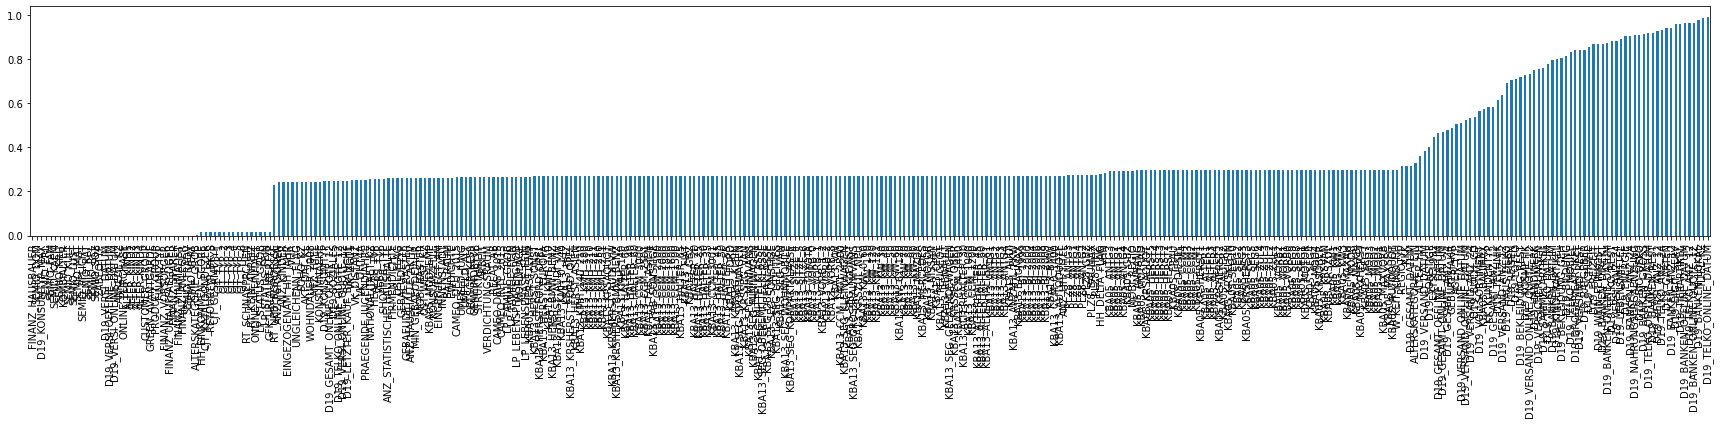

In [63]:
customers.isna().mean().sort_values().plot.bar(figsize=(24, 6));
plt.gcf().tight_layout()

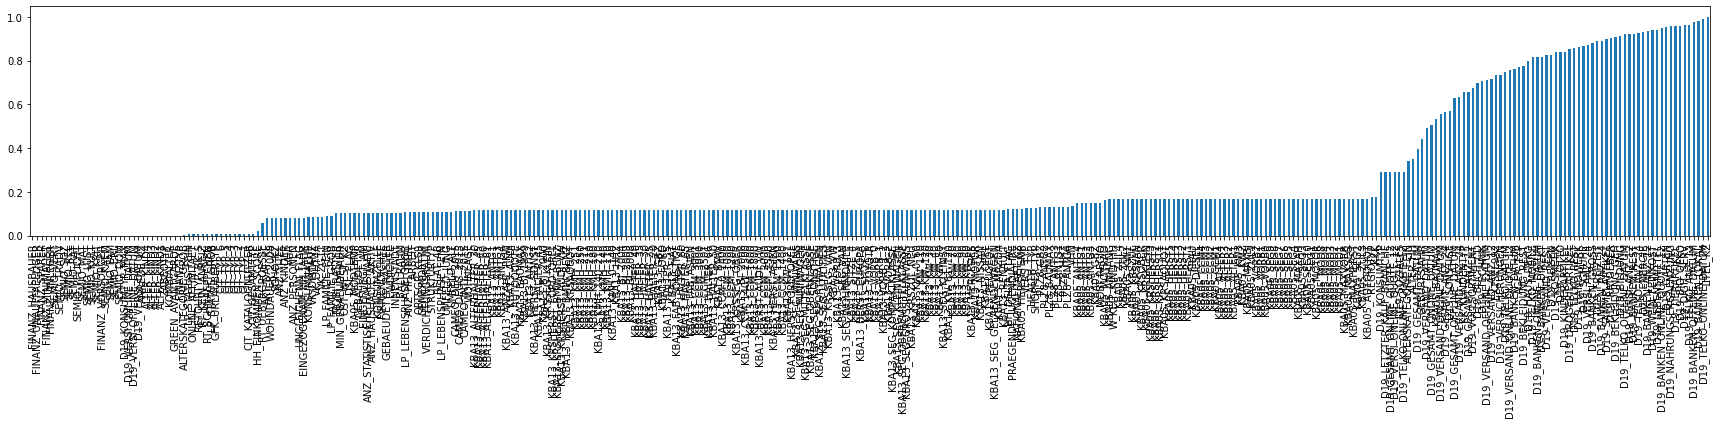

In [64]:
azdias.isna().mean().sort_values().plot.bar(figsize=(24, 6));
plt.gcf().tight_layout()

There seems to be a relatively pronounced split at the ~20% mark. We'll use that as a limit for dropping columns.

In [65]:
cols_to_drop = list(azdias.isna().mean()[azdias.isna().mean() > 0.20].index)
print(len(cols_to_drop), 'columns selected for being dropped')
print(customers.shape[1] - len(cols_to_drop), 'columns will remain in `customers`')

72 columns selected for being dropped
296 columns will remain in `customers`


In [66]:
# Drop the columns from both datasets
azdias = azdias.drop(cols_to_drop, axis=1)
customers = customers.drop(cols_to_drop, axis=1)
print(f"Number of columns dropped for excess of null values (>20%): {len(cols_to_drop)}")

Number of columns dropped for excess of null values (>20%): 72


Let's save a file with all the columns to be dropped from our datasets so we can use this information in the `preprocess_data.py` script

In [67]:
pd.DataFrame(cols_to_drop).to_csv('data/clean/cols_to_drop.csv', index=None, header=False)

Next step: Drop **rows** with many missing values

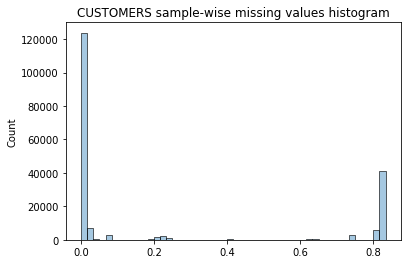

In [70]:
plt.figure()
sns.histplot(customers.isna().mean(axis=1), stat='count', alpha=0.4, bins=50)
plt.title('CUSTOMERS sample-wise missing values histogram');

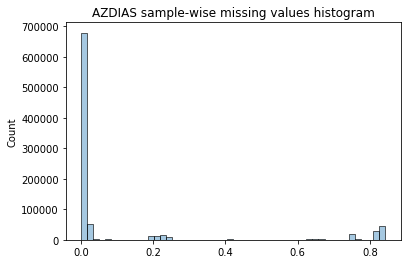

In [69]:
plt.figure()
sns.histplot(azdias.isna().mean(axis=1), stat='count', alpha=0.4, bins=50)
plt.title('AZDIAS sample-wise missing values histogram');

The majority of the rows contain less than 10% missing values, both in the customers as well as in the AZDIAS dataset. We'll drop any row missing more than 5% values for our analysis.

In [71]:
customer_na_percent_row = customers.isna().mean(axis=1)
azdias_na_percent_row = azdias.isna().mean(axis=1)
customers = customers.drop(customer_na_percent_row[customer_na_percent_row > 0.05].index)
azdias = azdias.drop(azdias_na_percent_row[azdias_na_percent_row > 0.05].index)

In [72]:
customers.shape, azdias.shape

((131218, 296), (732798, 293))

# Categorical variables cleanup
Let's look at the categorical variables described in the attributes file and do some additional cleanup.

In [73]:
cat_cols = dias_atts.groupby('Type').get_group('c')['Attribute']
print(f'There were {len(cat_cols)} categorical features described in the attributes file.')
cat_cols = cat_cols[cat_cols.isin(customers.columns)]
print(f'There are still {len(cat_cols)} categorical features in the attributes file and in the clean dataset.')

There were 37 categorical features described in the attributes file.
There are still 31 categorical features in the attributes file and in the clean dataset.


In [74]:
cats_in_azdias = [c for c in azdias.columns if azdias[c].dtype == object]
cats_in_azdias

all_categoricals = set(cats_in_azdias).union(set(cat_cols))
# Save the categorical columns to a file
pd.Series(list(all_categoricals)).to_csv('data/clean/cat_cols.csv', index=None, header=None)
all_categoricals


{'ANREDE_KZ',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GEBAEUDETYP_RASTER',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'KBA05_HERSTTEMP',
 'KBA05_MAXHERST',
 'KBA05_MODTEMP',
 'KBA05_SEG6',
 'KONSUMNAEHE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'PLZ8_BAUMAX',
 'PRAEGENDE_JUGENDJAHRE',
 'REGIOTYP',
 'RETOURTYP_BK_S',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'WOHNLAGE',
 'ZABEOTYP'}

# Impute missing values
Since all values are discrete, we'll impute every missing value with the mode of that column. This should work fine for our date column as well.

In [75]:
customers = customers.fillna(customers.mode().iloc[0])
azdias = azdias.fillna(azdias.mode().iloc[0])

In [76]:
print(f'Missing values in customers: {customers.isna().sum().sum()}')
print(f'Missing values in azdias: {azdias.isna().sum().sum()}')

Missing values in customers: 0
Missing values in azdias: 0


# Load clean data
We now have a clean dataset, with correctly mapped values based on our exploration and the available info spreadsheets. We've also dropped columns with a large portion of values missing, since those will probably not contribute to our work. 

We'll perform some optimizations, then save these under `data/clean` for the next steps of the analysis.

In [77]:
def is_discrete(val):
    return int(val) == val if not pd.isna(val) else True

customers.select_dtypes(float).applymap(is_discrete).mean().sort_values()

AKT_DAT_KL                  1.0
KBA13_KRSHERST_BMW_BENZ     1.0
KBA13_KRSHERST_FORD_OPEL    1.0
KBA13_KRSSEG_KLEIN          1.0
KBA13_KRSSEG_OBER           1.0
                           ... 
KBA05_VORB0                 1.0
KBA05_VORB1                 1.0
KBA05_VORB2                 1.0
KBA05_ZUL2                  1.0
ALTERSKATEGORIE_GROB        1.0
Length: 261, dtype: float64

In [78]:
azdias.select_dtypes(float).applymap(is_discrete).mean().sort_values()

AKT_DAT_KL                  1.0
KBA13_KRSHERST_BMW_BENZ     1.0
KBA13_KRSHERST_FORD_OPEL    1.0
KBA13_KRSSEG_KLEIN          1.0
KBA13_KRSSEG_OBER           1.0
                           ... 
KBA05_VORB0                 1.0
KBA05_VORB1                 1.0
KBA05_VORB2                 1.0
KBA05_ZUL2                  1.0
ALTERSKATEGORIE_GROB        1.0
Length: 261, dtype: float64

In [79]:
# Since all float columns are discrete, we can downcast all the values to the smallest integer type (up to int8)
def optimize_dataframe(df):
    df_ = df.copy()
    for c in df.columns:
        df_[c] = pd.to_numeric(df[c], errors='ignore', downcast='integer')
    
    return df_

# Let's optimize the CUSTOMERS dataset using this technique
print('Before downcast:')
customers.info()

print('\nAfter downcast:')
customers = optimize_dataframe(customers)
print(customers.info())

Before downcast:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 131218 entries, 9626 to 148883
Columns: 296 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(261), int64(30), object(4)
memory usage: 297.3+ MB

After downcast:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 131218 entries, 9626 to 148883
Columns: 296 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: int16(5), int64(1), int8(286), object(4)
memory usage: 43.0+ MB
None


In [80]:
# Same for AZDIAS
print('Before downcast:')
azdias.info()

print('\nAfter downcast:')
azdias = optimize_dataframe(azdias)
azdias.info()

Before downcast:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 732798 entries, 910220 to 825787
Columns: 293 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(261), int64(29), object(2)
memory usage: 1.6+ GB

After downcast:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 732798 entries, 910220 to 825787
Columns: 293 entries, AKT_DAT_KL to ALTERSKATEGORIE_GROB
dtypes: int16(5), int64(1), int8(285), object(2)
memory usage: 228.5+ MB


In [81]:
# Finally, load all the clean data to disk
azdias.to_parquet('data/clean/azdias.parquet')
customers.to_parquet('data/clean/customers.parquet')
cat_cols.to_csv('data/clean/cat_cols.csv', index=None, header=False)